- PROYECTO DE ML 

In [1]:
# Importar librerias necesarias

import pandas as pd
from surprise import SVD
from surprise import SVDpp
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Cargo el dataset de ratings

df = pd.read_parquet('rating_data.parquet')
df['score'] = df['score'].astype(float)
df.head()

,score,id,userid,date,title
0,1.0,as680,1,2015-03-09,the english civil war
1,4.5,ns2186,1,2015-03-09,latte and the magic waterstone
2,5.0,hs2381,1,2015-03-09,la diosa coronada
3,5.0,ns3663,1,2015-03-09,"frankenstein’s monster’s monster, frankenstein"
4,5.0,as9500,1,2015-03-09,kept woman


ANALISIS EXPLORATORIO

In [3]:
# Busco valores duplicados en la tabla
df[df.duplicated()]

,score,id,userid,date,title
2232,3.0,hs963,24,2001-01-20,kings of pain
2289,3.0,as6216,24,2001-01-20,sorority row
2290,2.0,as2674,24,2001-01-19,dhoom
3638,3.5,ns8019,43,2007-05-15,silent hill: revelation
4696,4.0,hs70,47,2000-10-02,men's college hockey
...,...,...,...,...,...
11021476,0.5,ns8754,124325,2017-03-27,withdrawn
11021637,0.5,ns7021,124325,2017-03-27,hridaynath
11021743,3.5,hs2760,124325,2017-03-27,mobile suit gundam the origin
11021766,0.5,ns4902,124325,2017-03-27,the clapper


In [4]:
# Tomo una muestra de los resultados anteriores
df[df['id'] == 'hs70'].sort_values('userid')

,score,id,userid,date,title
4579,4.0,hs70,47,2000-10-02,men's college hockey
4696,4.0,hs70,47,2000-10-02,men's college hockey
19341,3.5,hs70,231,2007-04-26,men's college hockey
40344,4.0,hs70,434,2006-12-08,men's college hockey
52613,5.0,hs70,551,2015-04-20,men's college hockey
...,...,...,...,...,...
9381368,3.0,hs70,269308,2008-10-29,men's college hockey
9438037,4.0,hs70,270036,2014-07-24,men's college hockey
9445788,3.0,hs70,270112,1996-08-20,men's college hockey
9472431,5.0,hs70,270331,1996-06-16,men's college hockey


In [5]:
print(f'La cantidad de registros duplicados es: {df.duplicated().sum()}')

La cantidad de registros duplicados es: 10466


In [6]:
# Elimino los valores duplicados
df.drop_duplicates(inplace= True)

In [7]:
# Hago conteo nuevamente
print(f'La cantidad de registros duplicados es: {df.duplicated().sum()}')

La cantidad de registros duplicados es: 0


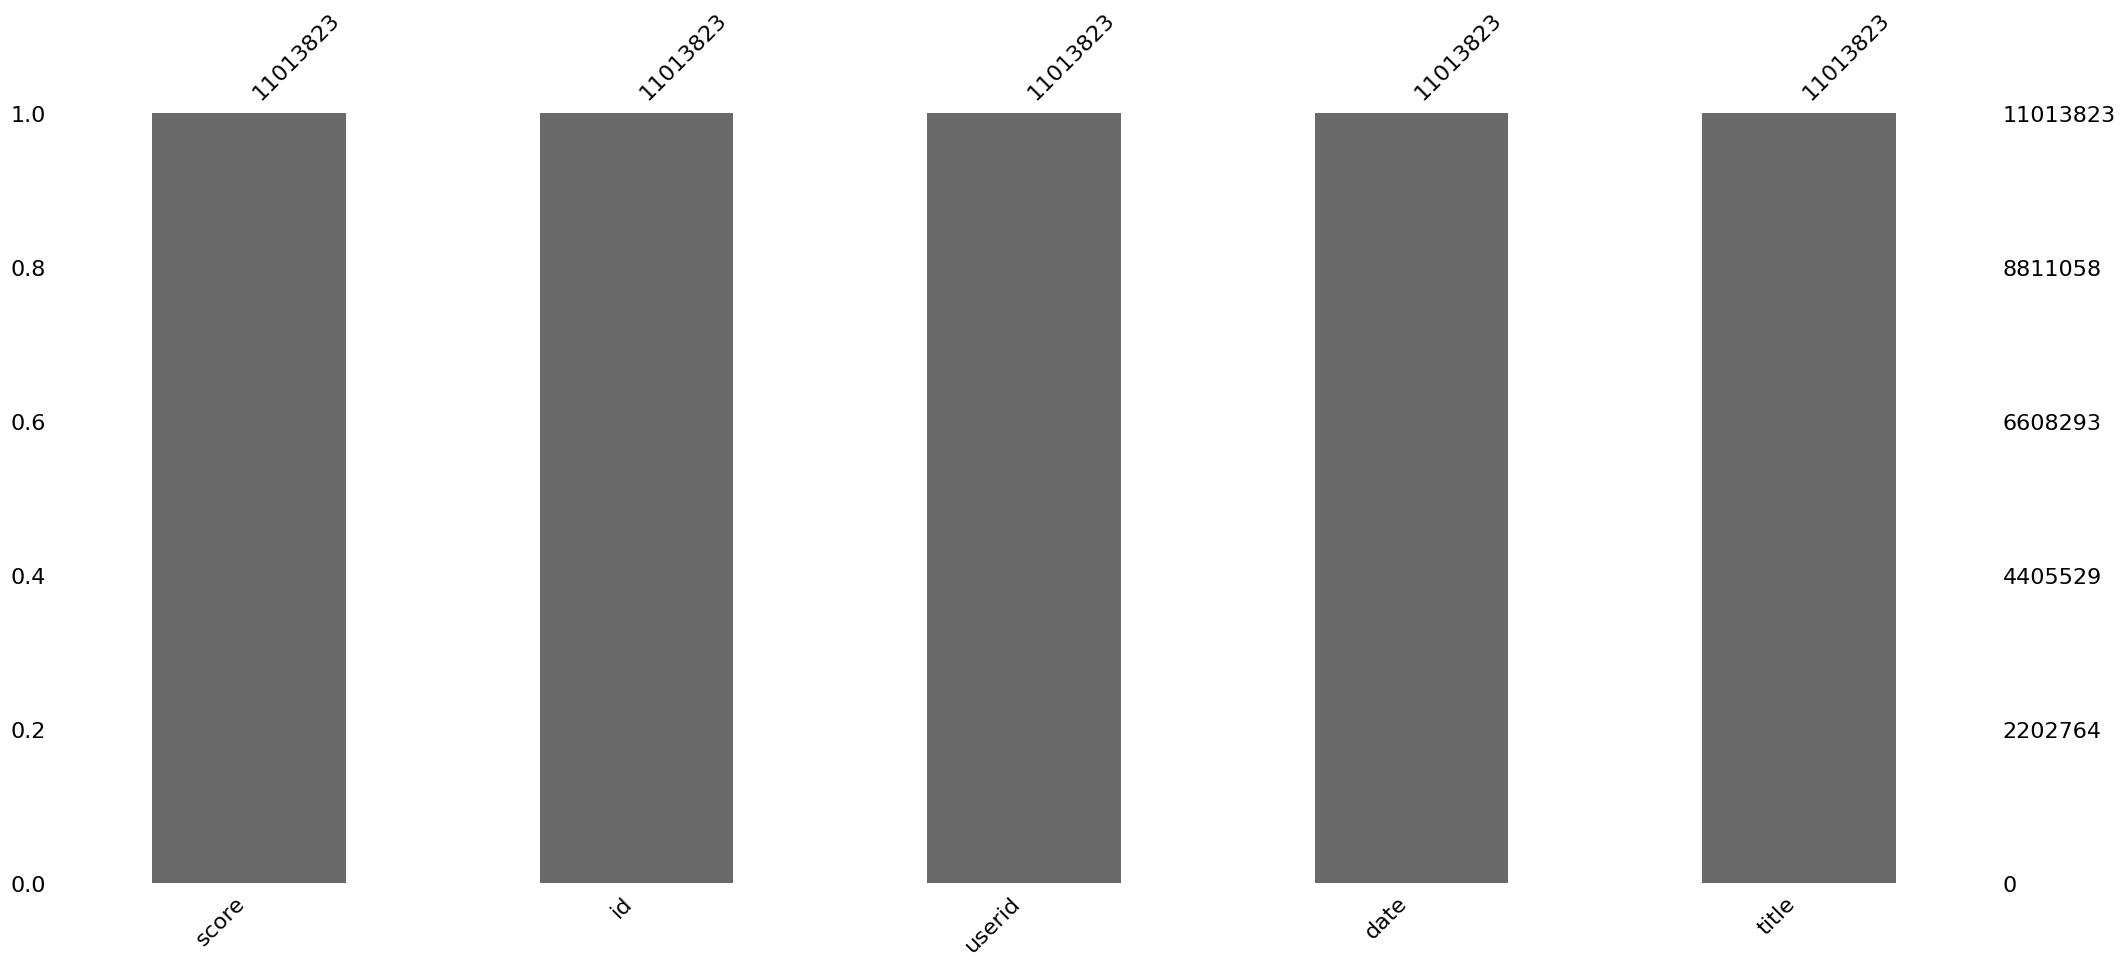

In [8]:
# Ahora a buscar valores faltantes
import missingno as msno

msno.bar(df)
plt.show()

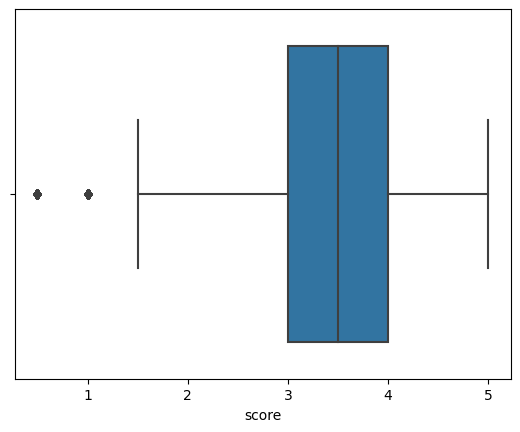

In [9]:
# Identificando valores atipicos

sns.boxplot(x = 'score', data = df)
plt.show()

In [10]:
# No existen valores atipicos
df.score.min()

0.5

In [11]:
# creo df de ratings
rating = df[['userid', 'id', 'score','title']]
rating.head()

,userid,id,score,title
0,1,as680,1.0,the english civil war
1,1,ns2186,4.5,latte and the magic waterstone
2,1,hs2381,5.0,la diosa coronada
3,1,ns3663,5.0,"frankenstein’s monster’s monster, frankenstein"
4,1,as9500,5.0,kept woman


MACHINE LEARNING

In [12]:
# Uso Reader para darle a los datos el formato que requiere el algoritmo
reader = Reader()
N = 100000
data = Dataset.load_from_df(rating[rating.columns[:3]][:N], reader)

In [13]:
#Separo los datos en test y entrenamiento

train, test = train_test_split(data, test_size=0.25)

In [14]:
#Instanciando el algoritmo y entrenamos
svd = SVD(n_factors= 1, n_epochs= 20, lr_all= 0.002, reg_all= 0.02)
svd.fit(train)
recom = svd.test(test)

In [15]:
# Evaluamos
print(accuracy.mae(recom))
accuracy.rmse(recom)

MAE:  0.7374
0.7374191723892628
RMSE: 0.9441


0.9440800267787791

OPTIMIZACION DE HIPERPARAMETROS

In [16]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(factor)
    model = SVD(n_factors=factor)
    cv = cross_validate(model, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9522  0.9500  0.9490  0.9504  0.0013  
Fit time          0.40    0.42    0.41    0.41    0.01    
Test time         0.26    0.18    0.16    0.20    0.04    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9530  0.9497  0.9482  0.9503  0.0020  
Fit time          0.44    0.45    0.44    0.44    0.01    
Test time         0.27    0.27    0.18    0.24    0.04    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9497  0.9481  0.9508  0.9495  0.0011  
Fit time          0.48    0.50    0.50    0.49    0.01    
Test time         0.17    0.18    0.26    0.20    0.04    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9534  0.9

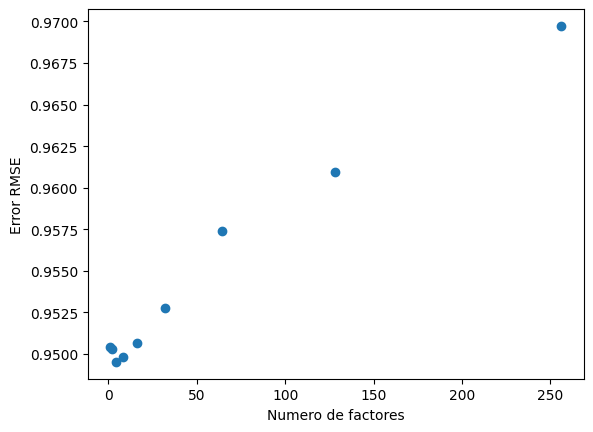

In [17]:
# Ploteamos desempeño según cantidad de factores de SVD

plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [18]:
# GridSearch para buscar perfomance del mejor modelo

from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [1,2,3,4,5],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

In [19]:
# Observamos performance del mejor modelo

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9438092155819469
{'n_factors': 2, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.02}


In [20]:
# Luego de optimizar el modelo procedo a entrenar con la data completa  

# Creo dataset completo
data_full = data.build_full_trainset()

In [21]:
#Instancio modelo
svd = SVD(n_factors= 1, n_epochs= 20, lr_all= 0.002, reg_all= 0.02)

#Entreno modelo
svd.fit(data_full)

In [22]:
#Pruebo la prediccion
svd.predict(5822, 'ns564')

Prediction(uid=5822, iid='ns564', r_ui=None, est=3.5852023276380223, details={'was_impossible': False})

In [64]:
# Desarollo la funcion
user = 1859
movie = 'ns45'
scoring = 4 # Variables de prueba

In [65]:
# Df con listado de todas las peliculas
all_movie = rating[['id', 'title']].drop_duplicates().set_index('id').iloc[:22998].copy()
all_movie

,title
id,
as680,the english civil war
ns2186,latte and the magic waterstone
hs2381,la diosa coronada
ns3663,"frankenstein’s monster’s monster, frankenstein"
as9500,kept woman
...,...
ns4069,a second chance
ds619,star wars: the clone wars
ns7976,secrets of scotland yard


In [66]:
# Df con las peliculas que el usuario ya vio

movie_saw = rating[rating['userid'] == user]
movie_saw

,userid,id,score,title
178508,1859,as45,4.0,yoga for relaxation anywhere
178509,1859,ns5369,4.0,the incredible jessica james
178510,1859,ns4416,4.0,brainchild
178511,1859,ns898,4.5,use for my talent
178512,1859,ns8652,4.5,tyson
...,...,...,...,...
179284,1859,as5744,3.5,mcgraw ave
179285,1859,ds1411,3.0,winnie the pooh: springtime with roo
179286,1859,ns6519,4.0,come and find me
179287,1859,hs1534,3.5,jillian's mystery craft box by pocket.watch


In [67]:
#Extraemos peliculas que ha visto
all_movie.drop(movie_saw.id, inplace= True)



In [68]:
all_movie = all_movie.reset_index()

In [69]:
# Recomendamos

all_movie['Estimate_Score'] = all_movie['id'].apply(lambda x: svd.predict(user, x).est)

In [70]:
recom_movie = all_movie.loc[all_movie['Estimate_Score'] >= scoring]
recom_movie

,id,title,Estimate_Score


In [71]:
title = rating[['id', 'title']].drop_duplicates().iloc[:22998]

In [76]:
if movie in recom_movie['id'].to_list():    
    print(f'La pelicula "{title[title.id == movie].iloc[0,1]}" esta recomendada para el usuario "{user}" se estima una calificacion de "{round(all_movie.iloc[0,2], 2)}"')

else:
    print(f'La pelicula "{title[title.id == movie].iloc[0,1]}" No esta recomendada para el usuario "{user}" si estimas una calificacion de {scoring}')

La pelicula "jaws: the revenge" No esta recomendada para el usuario "1859" si estimas una calificacion de 4


In [77]:
# Ensamblo cada parte de la funcion

def recommendation(user, movie, scoring):
    all_movie = rating[['id', 'title']].drop_duplicates().set_index('id').iloc[:22998].copy()
    
    movie_saw = rating[rating['userid'] == user]

    all_movie.drop(movie_saw.id, inplace= True)
    all_movie = all_movie.reset_index()
    all_movie['Estimate_Score'] = all_movie['id'].apply(lambda x: svd.predict(user, x).est)

    recom_movie = all_movie.loc[all_movie['Estimate_Score'] >= scoring]

    title = rating[['id', 'title']].drop_duplicates().iloc[:22998]

    recomendada = f'La pelicula "{title[title.id == movie].iloc[0,1]}" esta recomendada para el usuario "{user}" se estima una calificacion de "{round(all_movie.iloc[0,2], 2)}"'
    no_recomendada = f'La pelicula "{title[title.id == movie].iloc[0,1]}" No esta recomendada para el usuario "{user}" si estimas una calificacion de {scoring}'
   
    if movie in recom_movie['id'].to_list(): 
        return recomendada
    else:
        return no_recomendada
       

In [78]:
recommendation(1859, 'ns45', 4)

'La pelicula "jaws: the revenge" No esta recomendada para el usuario "1859" si estimas una calificacion de 4'

In [ ]:
#rating.to_parquet("deploy_data.parquet", index=False) # exportamos df de rating ya limpio para efectos del deployment

In [ ]:
# Guardamos el modelo
#import pickle
 
# Save the model under the cwd
#pkl_filename = "reco_movie.json"
#with open(pkl_filename, 'wb') as file:
    #pickle.dump(svd, file)